KeywordGraph: https://github.com/rangeonnicolas/keywordGraph/blob/master/keyWordGraph.py

CDlib - Community Discovery Library: https://cdlib.readthedocs.io/en/latest/index.html

TextRank-Keyword-Extraction: https://github.com/JRC1995/TextRank-Keyword-Extraction

In [ ]:
!python -m spacy download en_core_web_lg
!pip install sentence-transformers
!pip install gensim
!pip install networks
!pip install matplotlib
!pip install yake
!pip install editdistance==0.3.1
!pip install nltk

!pip install textgraphics
!pip install networkx
!pip install python-louvain
!pip install cdlib
!pip install communities
!pip install icecream

2021-03-30 17:44:06.908547: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-03-30 17:44:06.908583: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should 

In [ ]:
import sys
sys.path.insert(1, '/work/IFT6010_Story_Tree/src/features/')

#from keyword_extractor import f_measure
#from keyword_extractor import keyword_extractor

from keyWordGraph import KeywordGraph

from utils_cosine_tf_idf import get_corpus_tf_idf
from utils_cosine_tf_idf import do_cosine_similarity
import utils_cosine_tf_idf as util

import pandas as pd
from cdlib import algorithms
import networkx as nx
# import communities

#news_dataset["extracted_keywords"] = news_dataset["TEXT"].apply(keyword_extractor)
#news_dataset.to_pickle("/work/News_dataset/pd_news_dataset_2.pickle")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import Data

In [ ]:
# import numpy as np
# import re
# import nltk
# import itertools
# import yake
# import gensim

# from sklearn.feature_extraction.text import CountVectorizer
# from sentence_transformers import SentenceTransformer
# from sklearn.metrics.pairwise import cosine_similarity
# from nltk.corpus import stopwords
# from gensim.summarization import keywords as keywords_gensim
# import editdistance as Levenshtein
# import spacy

# #nlp = spacy.load("en_core_web_lg")
# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

# def keyword_extraction_baseline(text, number_keyword=40, language = "en", max_ngram_size = 1, deduplication_thresold = 0.9, deduplication_algo = 'seqm', windowSize = 1):
#     kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_thresold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=number_keyword, features=None)
#     keywords = kw_extractor.extract_keywords(text)
#     keywords_extractor = [i[0] for i in keywords] 

#     return keywords_extractor

In [ ]:
news_dataset = pd.read_pickle("/work/IFT6010_Story_Tree/data/short_news_dataset_2_with_extractedkeyword.pickle")

In [ ]:
news_dataset = news_dataset.drop_duplicates(subset=['TEXT'])

## Get TD-IDF 

In [ ]:

#arg 1 = dataframe source
#arg 2 = colomne d'ou le texte provient (je l'ai mis en argument parce que je ne connais pas la structure des autres dataframe)
##arg 3 = ngram a considerer... possible solution pour les keywords a n mots (n>1)

dataset_tf_idf, dict_weights = get_corpus_tf_idf(news_dataset,'TEXT',ngram=1)

# Create Graph with keyWordGraph

In [ ]:
import networkx as nx
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from icecream import ic

wordnet = WordNetLemmatizer()
porter = PorterStemmer()

# lemmatizer = wordnet.lemmatize
lemmatizer = porter.stem

def increment_edge (graph, node0, node1):
    # ic(node0, node1)
    
    if graph.has_edge(node0, node1):
        graph[node0][node1]["weight"] += 1.0
        # ic(node0, node1, graph[node0][node1]["weight"])
    else:
        graph.add_edge(node0, node1, weight=1.0)

def link_sentence (doc, lemma_graph, seen_lemma, count_lemma):
    visited_tokens = []
    visited_nodes = []
    visited_lemma = []

    for idx, token in enumerate(doc):

        lemma_key = lemmatizer(token)
        create_node = False
        if lemma_key not in seen_lemma:
            seen_lemma[lemma_key] = set([idx])
            create_node = True
        else:
            seen_lemma[lemma_key].add(idx)

        node_id = list(seen_lemma.keys()).index(lemma_key)

        if create_node:
            count_lemma[lemma_key] = 1
        else:
            count_lemma[lemma_key]+=1

        if not node_id in lemma_graph:
            lemma_graph.add_node(node_id)

        # ic(visited_tokens, visited_nodes)
        # ic(list(range(len(visited_tokens) - 1, -1, -1)))
        
        for prev_token in range(len(visited_tokens) - 1, -1, -1):
            # ic(prev_token, (idx - visited_tokens[prev_token]))
            
            if (idx - visited_tokens[prev_token]) <= 3:
                # ic(node_id)
                increment_edge(lemma_graph, lemma_key, visited_lemma[prev_token])
                # increment_edge(lemma_graph, node_id, visited_nodes[prev_token])
            else:
                break

        # ic(idx, token, lemma_key, len(visited_tokens), len(visited_nodes))

        visited_tokens.append(idx)
        visited_nodes.append(node_id)
        visited_lemma.append(lemma_key)

In [ ]:
from tqdm import tqdm

keyword_nxGraph_new = nx.Graph()
seen_lemma = {}
count_lemma = {}
keyword_list = list(news_dataset["extracted_keywords"])

# print(keyword_list[792])
for doc in tqdm(keyword_list):
    link_sentence(doc, keyword_nxGraph_new, seen_lemma, count_lemma)


filtered_node = [k for k, v in count_lemma.items() if v >= 6]
print(filtered_node)

keyword_nxGraph_filtered = keyword_nxGraph_new.subgraph(filtered_node)
print(len(keyword_nxGraph_filtered))

keyword_nxGraph = keyword_nxGraph_filtered
print(len(keyword_nxGraph))

100%|██████████| 827/827 [00:03<00:00, 254.57it/s]['facebook', 'world', 'monday', 'night', 'espn', 'footbal', 'new', 'star', 'like', 'adam', 'featur', 'seri', 'london', 'season', 'busi', 'pari', 'cnn', 'saturday', 'ghana', 'peopl', 'offici', 'said', 'kill', 'injur', 'octob', 'presid', 'spain', 'catalan', 'independ', 'barcelona', 'minist', 'spanish', 'govern', 'polic', 'referendum', 'cnnmoney', 'tuesday', 'brussel', 'madrid', 'franc', 'the european union', 'trump', 'tillerson', 'forb', 'donald', 'secretari', 'sourc', 'summer', 'tweet', 'cabinet', 'the white hous', 'sander', 'power', 'health', 'son', 'daughter', 'nurs', 'sister', 'diabet', 'massachusett', 'north carolina', 'epa', 'obama', 'bill', 'cnn health on facebook and twitt', 'success', 'price', 'news', 'person', 'polit', 'florida', 'june', 'presidenti', 'hurrican', "st. martin'", 'puerto rico', 'texa', 'the washington post', 'new jersey', 'white hous', "new york'", 'las vega', 'japan', 'offer', 'tokyo', 'south', 'chile', 'america'

# CDlib - Community Discovery Library

## Louvain community detection

In [ ]:
import cdlib

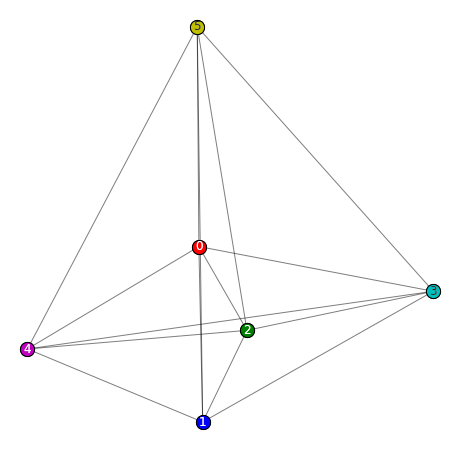

In [ ]:
from cdlib import algorithms, viz
keyword_communities = algorithms.louvain(keyword_nxGraph, weight='weight', resolution=1., randomize=False)
viz.plot_community_graph(keyword_nxGraph, keyword_communities, plot_labels= True)

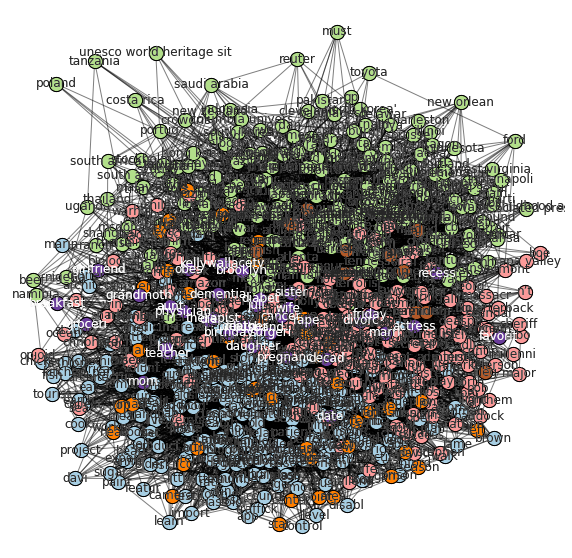

In [ ]:
keyword_communities = algorithms.louvain(keyword_nxGraph, weight='weight', resolution=1., randomize=False)
keyword_pos = nx.spring_layout(keyword_nxGraph)
# networkx_graph, dictionary = cdlib.utils.nx_node_integer_mapping(keyword_nxGraph)
# networkx_graph = keyword_nxGraph
viz.plot_network_clusters(keyword_nxGraph, keyword_communities, keyword_pos, figsize=(10, 10), cmap="Paired", plot_labels= True)

In [ ]:
import pickle
pickle.dump(keyword_communities.to_node_community_map(), open("extracted_communities.pickle",'wb'))

In [ ]:
#viz.plot_community_graph(keyword_nxGraph, keyword_communities, cmap="Paired", plot_labels= True)

# Evaluation of community with Cdlib

Evaluation meaning: https://hal.archives-ouvertes.fr/hal-02197272/document



Community Detection on Networks with Ricci Flow: https://www.nature.com/articles/s41598-019-46380-9.pdf

Experimental results. To evaluate the clustering accuracy of our algorithm, we tested the clustering result with
two diferent metrics: Adjusted Rand Index (ARI) and modularity. ARI measures the accuracy of clustering result
with the ground truth clustering. Modularity quantifes the strength of the community structure of a given graph
without the need of ground-truth clustering.

In [ ]:
keyword_communities = algorithms.louvain(keyword_nxGraph, weight='weight', resolution=1., randomize=False)

In [ ]:
keyword_pos = nx.spring_layout(keyword_nxGraph)
viz.plot_network_clusters(keyword_nxGraph, keyword_communities, keyword_pos, figsize=(9, 9), node_size=1200, cmap="viridis", plot_labels= True)

NameError: name 'viz' is not defined

In [ ]:
keyword_communities.average_internal_degree()
keyword_communities.average_internal_degree(summary=False)

[18.803418803418804,
 20.530973451327434,
 19.128205128205128,
 9.681818181818182,
 6.4,
 5.538461538461538,
 6.545454545454546,
 4.0,
 4.285714285714286]

In [ ]:
from cdlib import evaluation

# The average degree: 2eC/nC = number of community internal edges in C / number of community nodes in C
evaluation.average_internal_degree(keyword_nxGraph, keyword_communities)

FitnessResult(min=4.0, max=20.530973451327434, score=10.546005103822214, std=6.520021555845086)

In [ ]:
lp_coms = algorithms.label_propagation(keyword_nxGraph)

keyword_communities.normalized_mutual_information(lp_coms)

MatchingResult(score=0.0, std=None)

In [ ]:
evaluation.normalized_mutual_information(keyword_communities, lp_coms)

MatchingResult(score=0.0, std=None)

In [ ]:
lp_coms

In [ ]:
keyword_communities

In [ ]:
news_dataset.head()

,Unnamed: 0,KEYWORDS,SUMMARY,TEXT,TITLE,date,extracted_keywords,PREPROCESSING_TEXT,VECTOR
1,1,"['facebook', 'whats', 'world', 'unfolds', 'tam...",Chat with us in Facebook Messenger.\nFind out ...,Chat with us in Facebook Messenger. Find out w...,Tamagotchi is back,10-06-2017,"[messenger, facebook, chat, find, unfolds, hap...",chat us facebook messenger find 's happening w...,"{'chat': 0.010449574311118917, 'us': 0.0186084..."
2,2,"['jedi', 'shots', 'rey', 'force', 'wars', 'sta...","ESPN's ""Monday Night Football"" had bears, viki...","ESPN's ""Monday Night Football"" had bears, viki...",'Star Wars: The Last Jedi' trailer debuts on '...,10-06-2017,"[monday, trailer, night, rey, jedi, espn, foot...",espn 's monday night football '' bears vikings...,"{'espn': 0.0024385780614651397, 'monday': 0.00..."
3,3,"['clients', 'art', 'science', 'scent', 'collid...","Lyn Harris' independent space, Perfumer H , in...","This feature is part of ' Details ,' a new ser...",Art and science collide in this one-of-a-kind ...,10-06-2017,"[details, perfumer, harris', objects, feature,...",feature part details new series captures creat...,"{'feature': 0.0015220018995126942, 'part': 0.0..."
4,4,"['akufoaddo', 'tanker', 'incidents', 'dozens',...",(CNN) A tanker exploded near a gas station in ...,(CNN) A tanker exploded near a gas station in ...,"Seven killed, dozens injured in Ghana tanker e...",10-06-2017,"[cnn, accra, saturday, ghana, people, official...",cnn tanker exploded near gas station accra sat...,"{'tanker': 0.00027957512873095494, 'exploded':..."
5,5,"['spanish', 'independence', 'regions', 'meets'...","Carles Puigdemont, the President of Catalonia,...",(CNN) Pro-independence Catalans gathered on th...,Catalans' future on line as parliament meets,10-06-2017,"[spain, catalan, independence, puigdemont, bar...",cnn proindependence catalans gathered streets ...,"{'proindependence': 0.00012037100144982589, 'c..."


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=902703f2-430f-48f3-ba3f-6c2fee66cf11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>